In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, LSTM
from keras.layers import Dropout
from keras import backend as K
import os,sys

In [2]:
new_df = pd.read_csv("../data/new_df2.csv")
new_df.drop(columns = 'Unnamed: 0', inplace=True)
new_df.head()


,year,month,day,hour,date,pi_24,wd,ws,wsf,bp,...,ws48,wsf48,bp48,t248,t1048,tt48,rh48,ah48,pi48,pi_cat
0,2000,1,3,2,2000-01-03,0.0,1.281024,-0.146936,0.645370,0.282925,...,1.868523,0.606922,-2.440339,0.608098,0.374977,0.207046,-1.098161,-1.047166,-0.120294,0
1,2000,1,3,3,2000-01-03,0.0,1.295809,-0.153200,0.643234,0.322450,...,1.845136,0.606922,-2.214701,0.282678,0.151059,0.062762,-1.058842,-1.040104,-0.120294,0
2,2000,1,3,4,2000-01-03,0.0,1.310595,-0.159464,0.641098,0.361976,...,1.611266,0.646794,-1.901314,0.022342,-0.049290,-0.042172,-1.006417,-1.016329,-0.120294,0
3,2000,1,3,5,2000-01-03,0.0,1.325380,-0.165729,0.638962,0.401501,...,1.354009,0.606922,-1.564648,-0.135719,-0.155356,-0.068406,-0.993311,-1.019721,-0.120294,0
4,2000,1,3,6,2000-01-03,0.0,1.340165,-0.171993,0.636826,0.441026,...,1.108446,0.567050,-1.287077,-0.237994,-0.226068,-0.081522,-1.006417,-1.044338,-0.120294,0


Where                  
                                       
- `wd` = 'wind direction'
- `ws` = 'wind speed'
- `wsf` = "wind steadiness factor"
- `bp` = "barometric pressure" 
- `t2` = "temp at 2m" (degrees Celsius)
- `t10` = "temp at 10m" (degrees Celsius)
- `tt` = "temp at top of measuring device" (degrees Celsius)
- `rh` = "relative humidity" (percent)
- `ah` = "absolute humidity"
- `pi` = "precipitation intensity"
    - `pi_24` = rolling sum of the previous 24hr precipitation intensity

Time history (lag data): 48 (hrs)

- i.e. `wd6` is wind direction at 6hrs prior to time step of that row 

In [3]:
new_df.columns

Index(['year', 'month', 'day', 'hour', 'date', 'pi_24', 'wd', 'ws', 'wsf',
       'bp',
       ...
       'ws48', 'wsf48', 'bp48', 't248', 't1048', 'tt48', 'rh48', 'ah48',
       'pi48', 'pi_cat'],
      dtype='object', length=497)

In [4]:
new_df[["pi_24","wd","ws","wsf","bp","t2","t10","tt","rh","ah","pi"]].describe()

,pi_24,wd,ws,wsf,bp,t2,t10,tt,rh,ah,pi
count,1.748310e+05,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000
mean,1.050912e+00,-0.000203,-0.000403,-0.000276,0.000090,0.000293,0.000308,0.000234,0.000247,0.000315,0.000049
std,5.290562e+00,1.000060,0.999673,1.000109,1.000049,1.000040,1.000033,1.000095,1.000090,1.000056,1.000200
min,-2.220446e-16,-2.253021,-1.592754,-8.523828,-7.715977,-3.696744,-4.386241,-4.698621,-1.478243,-1.484958,-0.120294
25%,-2.220446e-16,-0.584339,-0.762515,-0.230396,-0.536740,-0.730773,-0.673905,-0.658660,-0.875354,-0.871730,-0.120294
50%,-2.220446e-16,-0.121524,-0.271388,0.367688,0.113313,-0.061338,0.009636,0.049645,-0.259359,-0.227685,-0.120294
75%,4.440892e-16,0.663988,0.547157,0.646794,0.673827,0.710373,0.681392,0.705483,0.789144,0.748664,-0.120294
max,1.260000e+02,2.302948,6.861650,7.385208,3.145103,3.341626,3.545195,3.289484,2.453643,3.133818,41.104188


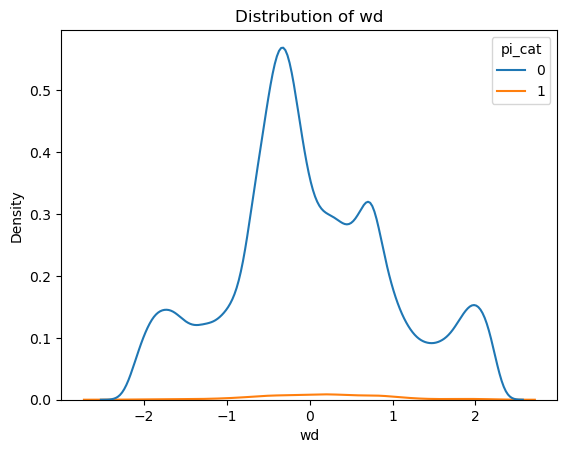

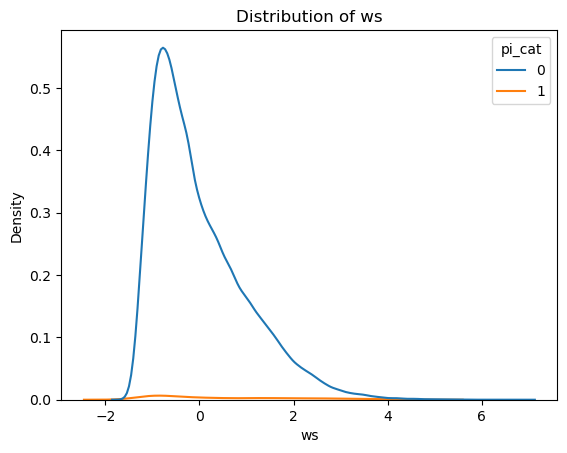

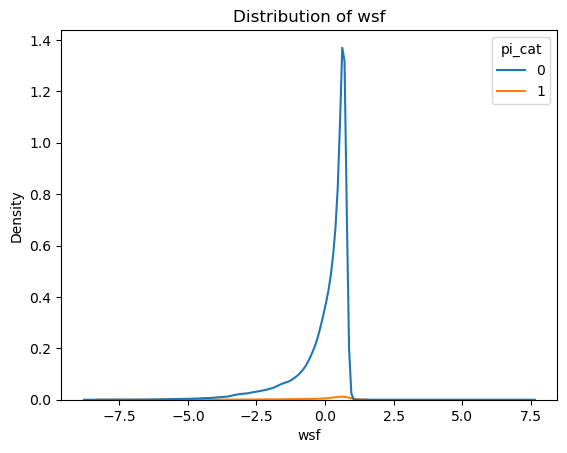

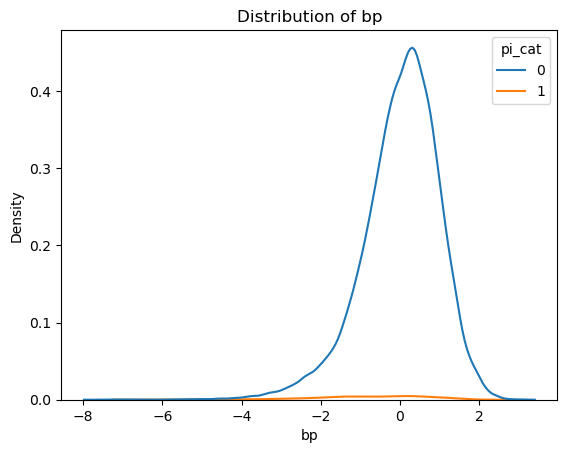

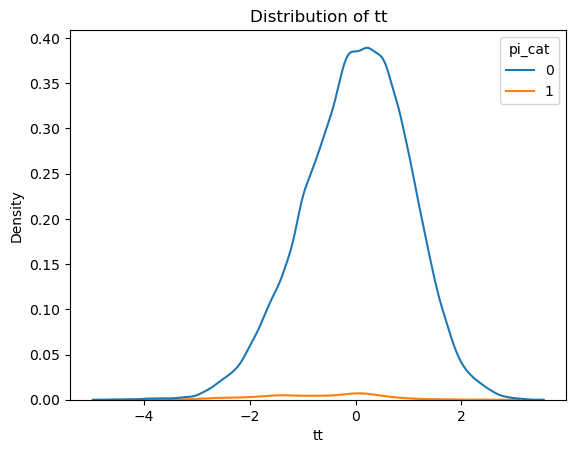

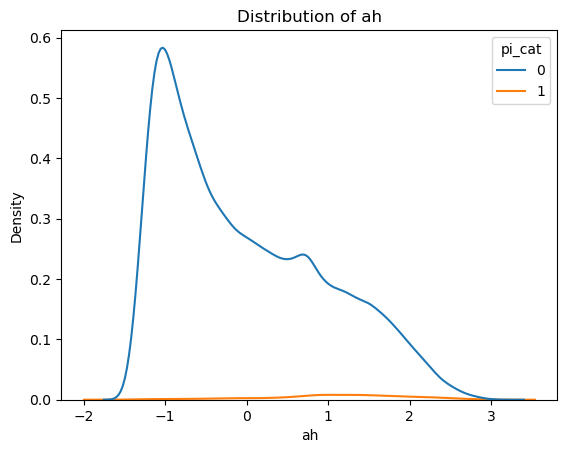

In [5]:
new_df['pi_cat'] = np.where(new_df.pi_24>15,1,0)

for f in ['wd', 'ws', 'wsf', 'bp', 'tt', 'ah']:
    plt.figure()
    sns.kdeplot(data=new_df,x=f, hue ="pi_cat").set(title='Distribution of {}'.format(f))
    plt.show

# Training, testing, features, targets

In [6]:
selective_features = ['wd', 'ws', 'wsf', 'bp', 'tt', 'ah', 'pi', 'wd3', 'ws3', 'wsf3', 'bp3',
                     'tt3', 'ah3', 'pi3', 'wd6', 'ws6', 'wsf6', 'bp6', 'tt6', 'ah6', 'pi6',
                     'wd9', 'ws9', 'wsf9', 'bp9', 'tt9', 'ah9', 'pi9']
cat_target = ['pi_cat']
reg_target = ['pi_24']

## Sequential split

In [7]:
#Ujas' code
split_index = round(new_df.shape[0] * 0.8)

test = new_df[split_index:]
train = new_df[:split_index]

In [8]:
X_train_seq = train[selective_features]
y_train_seq = train[['pi_cat']]
X_test_seq = test[selective_features]
y_test_seq = test[['pi_cat']]


In [9]:
scaler=StandardScaler()
X_train_seq = scaler.fit_transform(X_train_seq)
X_test_seq = scaler.transform(X_test_seq)

## Random split

In [10]:
X = new_df[selective_features]
cat_y = new_df[cat_target]
reg_y = new_df[reg_target]

In [11]:
X_train_rand,X_test_rand,y_train_rand,y_test_rand = train_test_split(X,cat_y,test_size= 0.2,random_state=123)

In [12]:
scaler=StandardScaler()
X_train_rand = scaler.fit_transform(X_train_rand)
X_test_rand = scaler.transform(X_test_rand)

# KNN

In [13]:
KNN = KNeighborsClassifier(n_neighbors=1, metric='cosine', n_jobs=-1)

KNN.fit(X = X_train_rand, y = y_train_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=1)

In [14]:
%%time
preds = KNN.predict(X_test_rand)

CPU times: total: 3min 53s
Wall time: 2min 4s


In [15]:
confusion_matrix(y_test_rand, preds)

array([[34228,   117],
       [  153,   469]], dtype=int64)

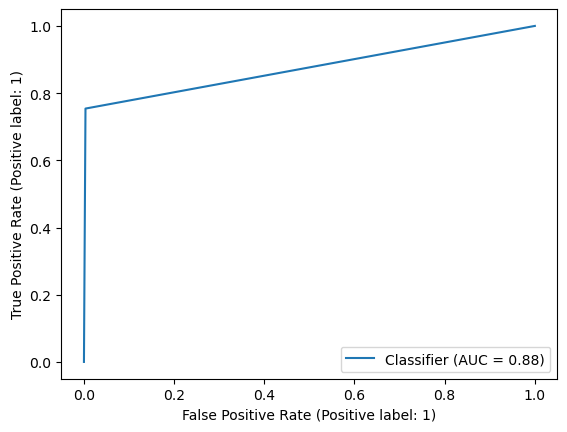

CPU times: total: 3min 51s
Wall time: 2min 2s


In [16]:
%%time
KNN_proba = KNN.predict_proba(X_test_rand)

RocCurveDisplay.from_predictions(y_test_rand, KNN_proba[:,1])
plt.show()

In [17]:
f1_score(y_test_rand, preds)

0.7764900662251657

In [18]:
accuracy_score(y_test_rand, preds)

0.9922784339520119

# Random Forest

In [19]:
%%time
RF = RandomForestClassifier(n_jobs= -1, class_weight=None)

RF.fit(X = X_train_rand, y = y_train_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CPU times: total: 3min 21s
Wall time: 29 s


RandomForestClassifier(n_jobs=-1)

In [20]:
RF.feature_importances_

array([0.03355342, 0.04315101, 0.02884638, 0.03865097, 0.03532539,
       0.05143479, 0.08009957, 0.03241817, 0.04016719, 0.02698469,
       0.03583797, 0.03247041, 0.03824117, 0.03193723, 0.0311411 ,
       0.04003187, 0.02695608, 0.03573051, 0.03107176, 0.03862459,
       0.01855511, 0.0333106 , 0.0373379 , 0.02865924, 0.03779281,
       0.03291117, 0.04396339, 0.01479552])

In [21]:
%%time
RF_preds = RF.predict(X_test_rand)

CPU times: total: 1.53 s
Wall time: 232 ms


In [22]:
%%time
RF_proba = RF.predict_proba(X_test_rand)

CPU times: total: 1.53 s
Wall time: 349 ms


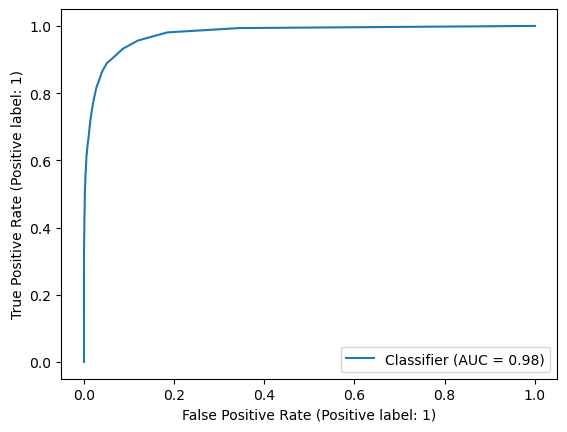

In [23]:
RocCurveDisplay.from_predictions(y_test_rand, RF_proba[:,1])

In [24]:
confusion_matrix(y_test_rand, RF_preds)

array([[34343,     2],
       [  447,   175]], dtype=int64)

In [25]:
f1_score(y_test_rand, RF_preds)

0.4380475594493116

In [26]:
accuracy_score(y_test_rand, RF_preds)

0.9871593216461235

# RandomForest Regressor

In [27]:
X_train_rand,X_test_rand,reg_y_train_rand,reg_y_test_rand = train_test_split(X,reg_y,test_size= 0.2,random_state=123)

In [28]:
%%time
RF = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state = 123)

RF.fit(X = X_train_rand, y = reg_y_train_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CPU times: total: 44min 36s
Wall time: 6min 23s


RandomForestRegressor(n_jobs=-1, random_state=123)

In [29]:
%%time
RF_preds = RF.predict(X_test_rand)

CPU times: total: 3.17 s
Wall time: 607 ms


In [30]:
from sklearn.metrics import r2_score
r2_score(reg_y_test_rand, RF_preds)

0.5870201879500845

In [31]:
RF_preds

array([ 1.63000000e+00,  5.90000000e-01,  3.00000000e-02, ...,
        5.70000000e-01, -5.39980824e-17,  2.11555556e+00])

In [32]:
cat_pred = np.where(RF_preds>15,1,0)

In [33]:
confusion_matrix(y_test_rand,cat_pred)

array([[34258,    87],
       [  405,   217]], dtype=int64)

# GRU

In [34]:
X_train = np.array(X_train_rand).reshape(X_train_rand.shape[0],-1, 7)
X_test = np.array(X_test_rand).reshape(X_test_rand.shape[0],-1, 7)

In [35]:
%%time
class_weights = {0: 1., 1: 70.}
grumod = Sequential()

grumod.add(LSTM(units = 10, return_sequences = True, input_shape = (4, 7)))
grumod.add(Dropout(0.2))

grumod.add(LSTM(units = 3, return_sequences = False))
grumod.add(Dropout(0.2))

grumod.add(Dense(units = 1, activation='sigmoid'))

grumod.compile(optimizer = 'adam', loss = 'binary_crossentropy')

history = grumod.fit(X_train, y_train_rand, validation_data=(X_test,y_test_rand), epochs = 50, batch_size = 512, class_weight = class_weights)

Epoch 1/50
274/274 [==============================] - 12s 21ms/step - loss: 1.2412 - val_loss: 0.5284
Epoch 2/50
274/274 [==============================] - 4s 14ms/step - loss: 0.9911 - val_loss: 0.4761
Epoch 3/50
274/274 [==============================] - 4s 14ms/step - loss: 0.9285 - val_loss: 0.4412
Epoch 4/50
274/274 [==============================] - 4s 14ms/step - loss: 0.9047 - val_loss: 0.4015
Epoch 5/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8827 - val_loss: 0.4252
Epoch 6/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8718 - val_loss: 0.4447
Epoch 7/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8560 - val_loss: 0.3869
Epoch 8/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8411 - val_loss: 0.4117
Epoch 9/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8411 - val_loss: 0.3949
Epoch 10/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8302 - val_l

In [36]:
gru_preds = grumod.predict(X_test[:,:10,:])

1093/1093 [==============================] - 7s 4ms/step


In [37]:
confusion_matrix(y_test_rand,np.round(gru_preds))

array([[28122,  6223],
       [   62,   560]], dtype=int64)

In [38]:
f1_score(y_test_rand,np.round(gru_preds))

0.1512491559756921

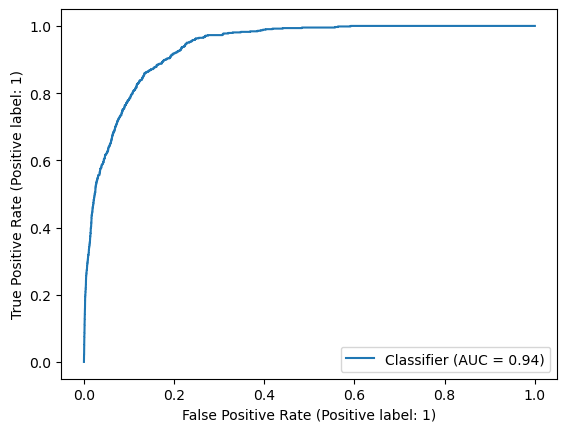

In [39]:
RocCurveDisplay.from_predictions(y_test_rand,gru_preds)